In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import ast
import re
import numpy as np

def process_csv(file_path):
    """Process a CSV file containing loss data"""
    df = pd.read_csv(file_path)
    df['value'] = df['value'].apply(lambda x: ast.literal_eval(x)[0])
    df = df.drop_duplicates(subset=['step'], keep='last')
    return df

def extract_number(filename):
    """Extract the final number from the filename"""
    # Find the last number in the filename
    numbers = re.findall(r'\d+', filename)
    return int(numbers[-1]) if numbers else None

def plot_loss_graphs(directory_path, percentile_cutoff=1, limit=False):
    """
    Plot loss graphs with automatic outlier handling using percentiles
    
    Args:
        directory_path: Path to directory containing CSV files
        percentile_cutoff: Percentile cutoff for outliers (default: 1)
    """
    # Extract postfix (after last "/") from directory path
    tag = directory_path.split('/')[-1]
    
    # Get all loss CSV files
    files = glob.glob(os.path.join(directory_path, f'*_{tag}.csv'))
    
    if not files:
        print(f"No CSV files found in {directory_path}")
        return
    
    plt.figure(figsize=(12, 8))
    
    # Create color mapping
    unique_numbers = {extract_number(os.path.basename(f)) for f in files if extract_number(os.path.basename(f)) is not None}
    color_map = plt.cm.tab10(np.linspace(0, 1, len(unique_numbers)))
    number_to_color = dict(zip(sorted(unique_numbers), color_map))
    
    # Sort files for consistent ordering
    files.sort(key=lambda x: (extract_number(os.path.basename(x)), '_fixed' in x))
    
    # Collect all values for percentile calculation
    all_values = []
    
    # First pass: collect all values
    for file_path in files:
        try:
            df = process_csv(file_path)
            all_values.extend(df['value'].values)
        except Exception as e:
            print(f"Error processing {os.path.basename(file_path)}: {e}")
    
    # Calculate percentile bounds
    lower_bound = np.percentile(all_values, percentile_cutoff)
    upper_bound = np.percentile(all_values, 100 - percentile_cutoff)
    
    # Second pass: plot with adjusted bounds
    for file_path in files:
        filename = os.path.basename(file_path)
        name = filename.replace(f'_{tag}.csv', '')
        
        try:
            df = process_csv(file_path)
            
            # Determine color and style
            num = extract_number(filename)
            color = number_to_color[num] if num is not None else 'gray'
            style = ':' if '_fixed' in filename else '-'
            
            plt.plot(df['step'], df['value'],
                    label=name,
                    color=color,
                    linestyle=style,
                    linewidth=2,
                    alpha=0.7)
            
        except Exception as e:
            print(f"Error processing {filename}: {e}")
    
    plt.xlabel('Steps')
    plt.ylabel(tag.title())
    plt.title(f'{tag.title()} Curves Comparison')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.yscale('log')
    
    # Set y-axis limits with some padding
    padding_factor = 1.1  # 10% padding
    if limit:
        plt.ylim(lower_bound / padding_factor, upper_bound * padding_factor)
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

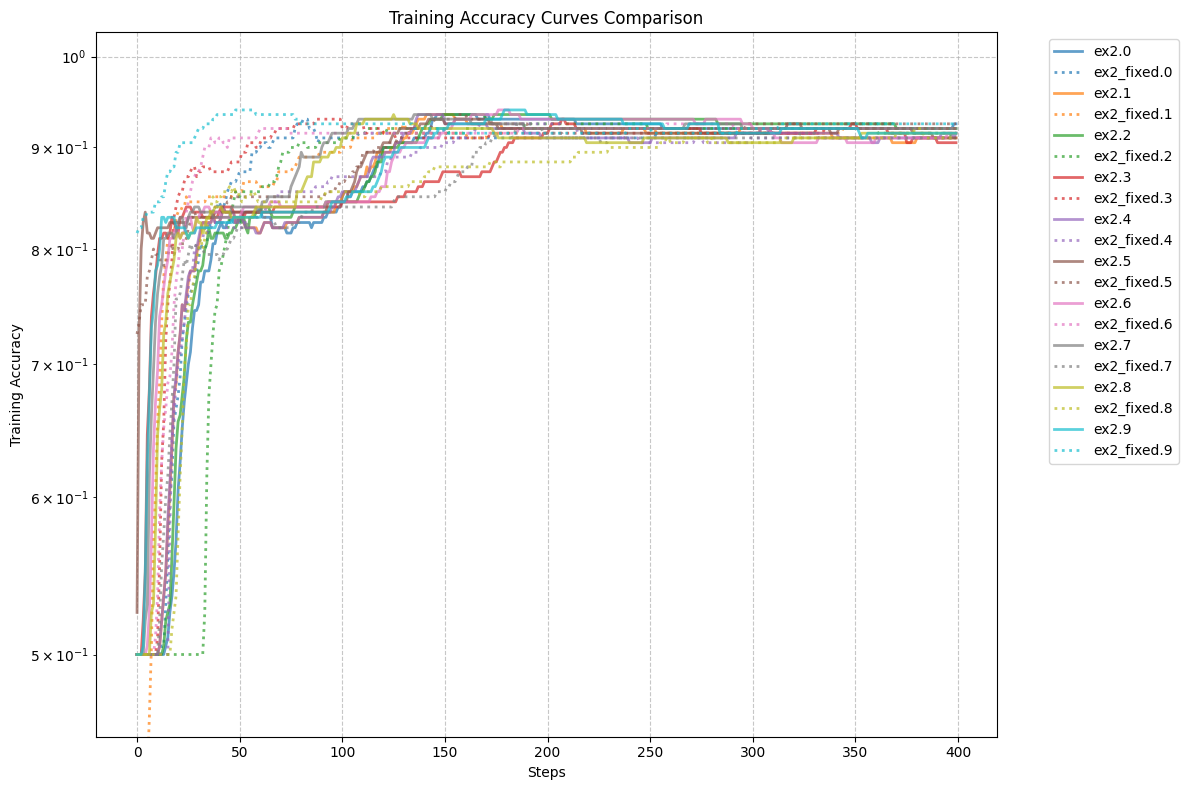

In [31]:
# Example usage
tag = "training accuracy"
ex = "2"
limit = True
plot_loss_graphs(f"/work/inestp02/xipe_markus/self-expanding-neural-networks/senn_mlp/tensorboard_exports/experiment{ex}/{tag}", limit=limit)

In [22]:
def plot_mean_std_loss(directory_path, percentile_cutoff=1, limit=False):
    """
    Plot mean loss graphs with standard deviation bands, correctly handling log-scale statistics
    """
    tag = directory_path.split('/')[-1]
    files = glob.glob(os.path.join(directory_path, f'*_{tag}.csv'))
    
    if not files:
        print(f"No CSV files found in {directory_path}")
        return
    
    plt.figure(figsize=(12, 8))
    
    # Separate fixed and non-fixed files
    fixed_files = [f for f in files if '_fixed' in os.path.basename(f)]
    non_fixed_files = [f for f in files if '_fixed' not in os.path.basename(f)]
    
    all_values_for_bounds = []
    
    # Process each group
    for files_group, label, color in [(fixed_files, 'Fixed', 'green'), 
                                    (non_fixed_files, 'Non-fixed', 'orange')]:
        if not files_group:
            continue
            
        all_values = []
        all_steps = set()
        
        # Process each file
        for file_path in files_group:
            try:
                df = process_csv(file_path)
                all_values.append(df)
                all_steps.update(df['step'])
                all_values_for_bounds.extend(df['value'].values)
            except Exception as e:
                print(f"Error processing {os.path.basename(file_path)}: {e}")
                continue
        
        if not all_values:
            continue
            
        common_steps = sorted(all_steps)
        aligned_values = []
        
        for df in all_values:
            full_df = pd.DataFrame({'step': common_steps})
            merged = pd.merge(full_df, df, on='step', how='left')
            merged['value'] = merged['value'].interpolate(method='linear')
            aligned_values.append(merged['value'].values)
        
        values_array = np.array(aligned_values)
        
        # Calculate statistics in log space
        log_values = np.log10(values_array)
        mean_log = np.mean(log_values, axis=0)
        std_log = np.std(log_values, axis=0)
        
        # Convert back to linear space
        mean_values = 10**mean_log
        lower_bound = 10**(mean_log - std_log)
        upper_bound = 10**(mean_log + std_log)
        
        # Plot mean line
        plt.plot(common_steps, mean_values, label=label, color=color, linewidth=2)
        
        # Plot standard deviation area
        plt.fill_between(common_steps, 
                        lower_bound,
                        upper_bound,
                        color=color, alpha=0.2)
    
    # Set y-axis limits if requested
    if limit and all_values_for_bounds:
        lower_bound = np.percentile(all_values_for_bounds, percentile_cutoff)
        upper_bound = np.percentile(all_values_for_bounds, 100 - percentile_cutoff)
        padding_factor = 1.1
        plt.ylim(lower_bound / padding_factor, upper_bound * padding_factor)
    
    plt.xlabel('Steps')
    plt.ylabel(tag.title())
    plt.title(f'{tag.title()} Mean Curves with Standard Deviation')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.yscale('log')
    plt.legend()
    plt.tight_layout()
    plt.show()

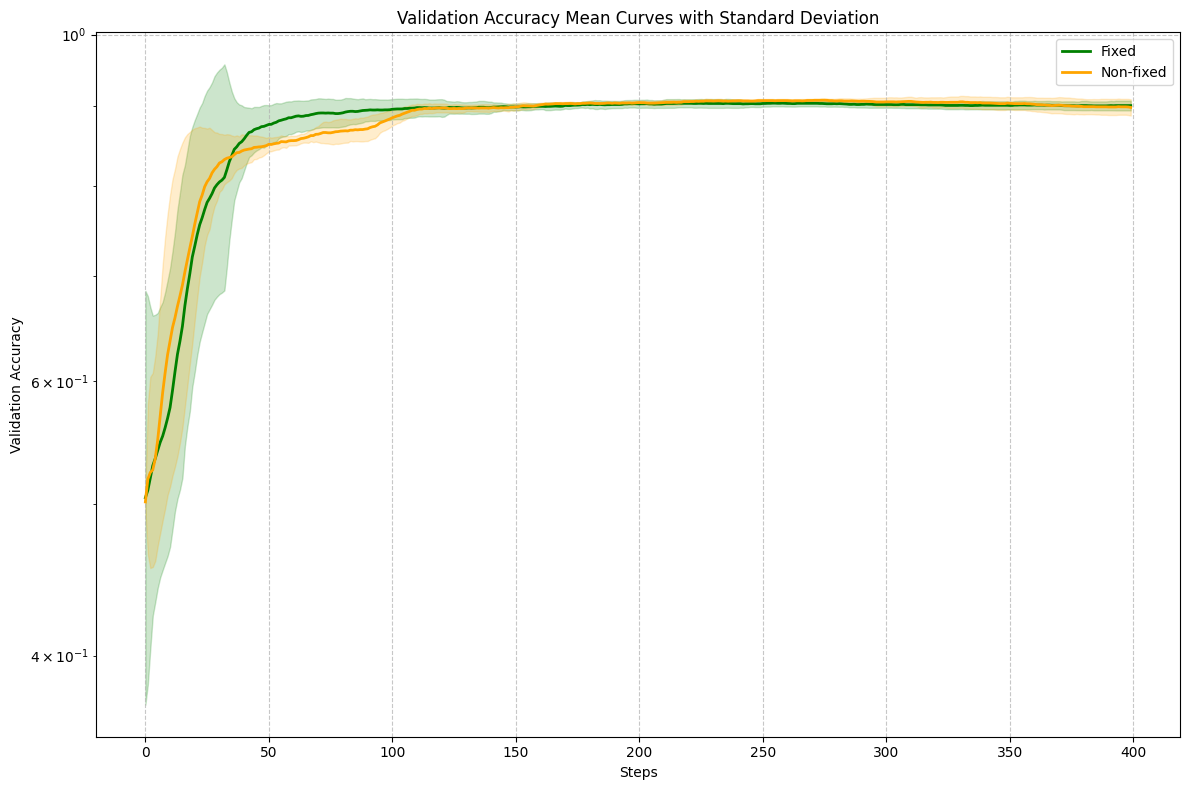

In [32]:
# Example usage
tag = "validation accuracy"
ex = "2"
limit = False
plot_mean_std_loss(f"/work/inestp02/xipe_markus/self-expanding-neural-networks/senn_mlp/tensorboard_exports/experiment{ex}/{tag}", limit=limit)